# Machine Learning: Intermediate report



## 1. Multi-class classification on MNIST


### Prepare dataset

In [2]:
!pip install livelossplot

In [ ]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    # -N : refresh time stamps
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

### Implement SGD

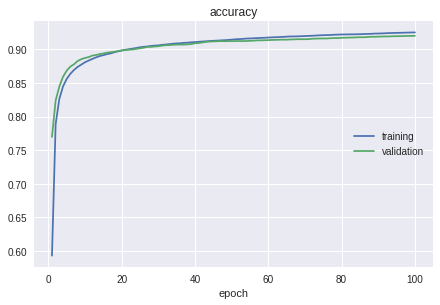

Accuracy: 0.9201 (test), 0.9252 (train)


In [3]:
import numpy as np
from livelossplot import PlotLosses

def softmax(x):
    # Result of softmax are invariant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()


for t in range(100):
    num_correct_train = 0
    
    
    #list
    y_true = []
    y_prob_true = []
    y_pred_miss_max = []
    y_pred_prob_miss_max = []
    y_prob_miss_index = []


    # Stochastic gradient descent.
    for i, (x, y)  in enumerate( zip(Xtrain, Ytrain)) :
      
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
        if  np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1
            
        # dataframe  -> 3)
        else :
          
            y_true.append(np.argmax(y))
            y_prob_true.append(y_pred[np.argmax(y)])
            y_pred_miss_max.append(np.argmax(y_pred))
            y_pred_prob_miss_max.append(np.max(y_pred))
            y_prob_miss_index.append(i)
            
    # Evaluate and store the accuracy on the test set.
    y_pred_array = []
    
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        y_max = np.max(np.dot(W,x))
        y_pred_array.append(y_pred)
          
        if y_pred == y:
            num_correct_test += 1

    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()
                
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest), 
    float(num_correct_train) / len(Ytrain)
    ))

## 2. Confusion matrix


In [4]:
from sklearn.metrics import  confusion_matrix

confusion_matrix( Ytest,y_pred_array)

array([[ 953,    0,    1,    1,    0,   11,    7,    2,    2,    3],
       [   0, 1107,    5,    0,    0,    2,    3,    2,   15,    1],
       [   8,    9,  921,   15,    6,    8,   13,    9,   41,    2],
       [   6,    1,   20,  906,    1,   33,    3,    9,   20,   11],
       [   2,    1,    6,    2,  904,    2,    9,    5,   10,   41],
       [   7,    2,    7,   32,   11,  788,   13,    3,   22,    7],
       [   8,    3,   10,    0,    6,   22,  903,    3,    3,    0],
       [   1,    6,   22,    7,    6,    4,    0,  936,    4,   42],
       [   6,    9,    7,   20,   11,   36,   11,    7,  856,   11],
       [  10,    6,    1,    8,   24,    8,    0,   18,    7,  927]])

## 3. Top-3 confusing examples


### List to dataframe

In [5]:
import pandas as pd
pd.options.display.precision = 20


df = pd.DataFrame({'index':y_prob_miss_index,'y_true':y_true,  'y_true_prob':y_prob_true ,\
                          'y_pred': y_pred_miss_max, 'y_pred_prob':y_pred_prob_miss_max})

df = df[['index', 'y_true', 'y_true_prob', 'y_pred', 'y_pred_prob']]
df.head()


,index,y_true,y_true_prob,y_pred,y_pred_prob
0,18,6,0.41053199668366185948,5,0.49095424972764567517
1,33,9,0.35184206158227787631,7,0.63470096112457741189
2,48,9,0.17669272523444121137,5,0.73771008023066142467
3,80,9,0.00017502497780537223,8,0.53890879217957377012
4,109,2,0.27871570542317869457,6,0.66255355554278150265


In [6]:
df_sort = df.sort_values( "y_pred_prob" , ascending= False).copy()

df_sort.head()

,index,y_true,y_true_prob,y_pred,y_pred_prob
1842,24798,4,0.00000000168051735630,0,0.99999913954904118274
559,7851,8,0.00000027282628683078,0,0.99999664436711888094
1531,20735,9,0.00000008067750456840,0,0.99999568787382275836
2017,27219,7,0.00000129570109662263,2,0.99999188358142288013
1996,26882,7,0.00000000000185289342,0,0.99998358611260040885


True digit : 4 (1.6805173563010424e-09)  ; prediction : 0 (0.9999991395490412)


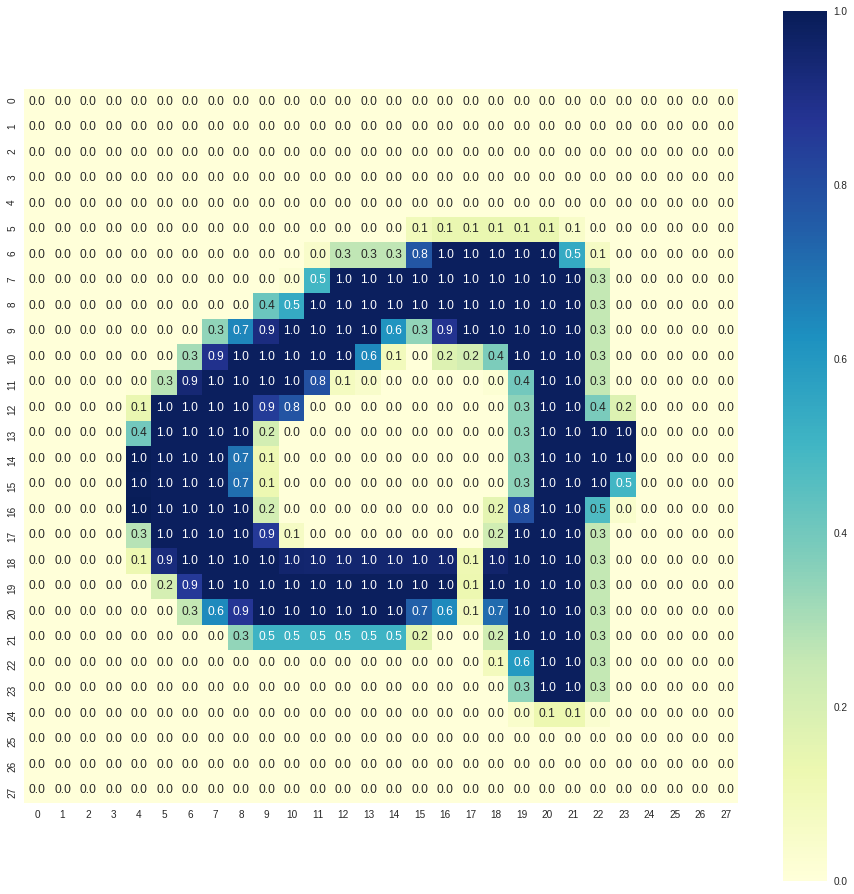

True digit : 8 (2.7282628683077597e-07)  ; prediction : 0 (0.9999966443671189)


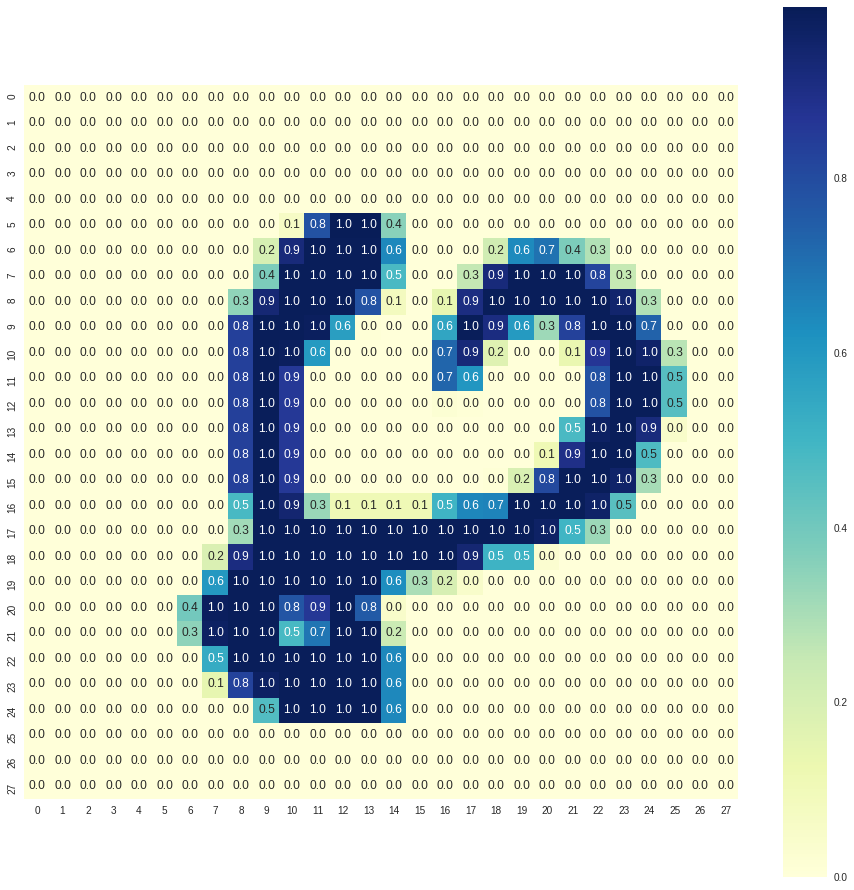

True digit : 9 (8.0677504568399e-08)  ; prediction : 0 (0.9999956878738228)


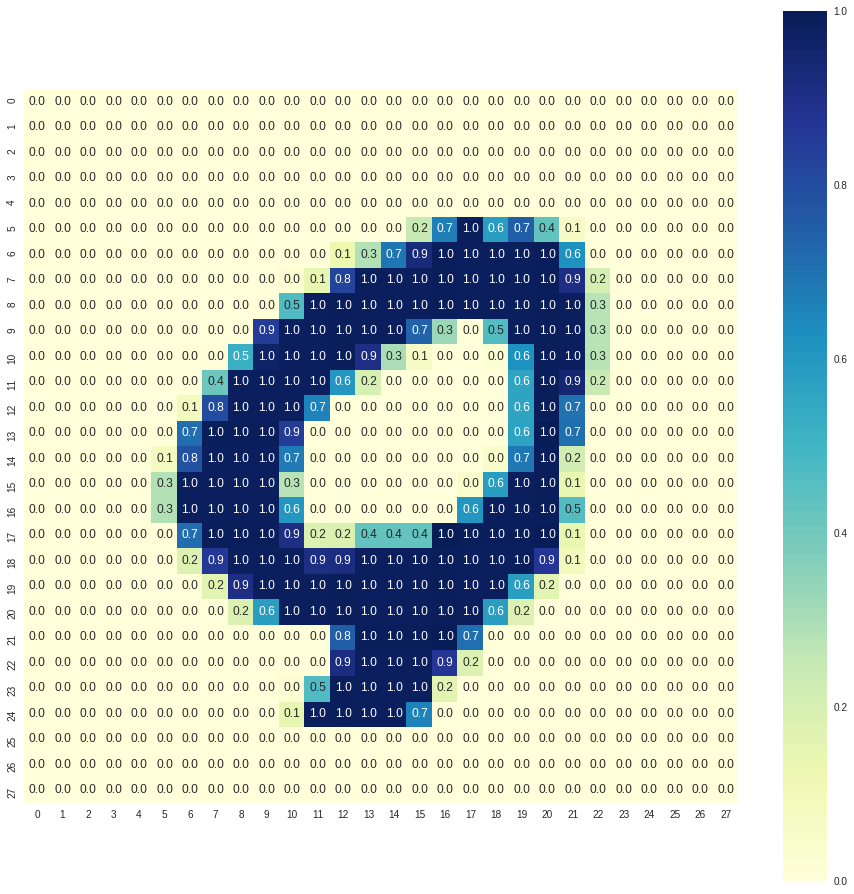

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).

for i  in range(3):
    
    print( "True digit : {} ({}) ".format(int(df_sort.iloc[i][1]),  df_sort.iloc[i][2] ), "; prediction : {} ({})".format(int(df_sort.iloc[i][3]) ,  df_sort.iloc[i][4]))
    
    original_index = df_sort.iloc[i, 0]
    
    image = data['train_x'][ original_index ]  
    label = data['train_y'][original_index]
    
    f, ax = plt.subplots(figsize=(16, 16))
    sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
    plt.show()